In [50]:
# import itertools
import os
import sys
from pathlib import Path

import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import skimage.io

from collections import defaultdict
from tqdm.auto import tqdm
from joblib import Parallel, delayed
import re
import h5py
import napari
import tifffile as tiff
import seaborn as sns
import pickle

In [51]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [52]:
p_dir = (Path().cwd().parents[0]).absolute()

module_path = str(p_dir / "src")

if module_path not in sys.path:
    sys.path.append(module_path)

In [53]:
data_dir = (Path().cwd().parents[0] / 'data').absolute()
fig_dir = (Path().cwd().parents[0] / 'figure').absolute()

df_meta_path = data_dir / '9PPI Cell Culture' / 'Whole' / 'metadata' /  'imgs_reg_norm.csv'
df_imgs = pd.read_csv(df_meta_path)

# Viz images

In [54]:
def plot_spot_on_image(reference, spots, spacing, radius):
    spot_img = np.zeros_like(reference)
    coords = (spots[:, :3] / spacing).astype(int)
    r = radius  # shorthand
    for coord in coords:
        slc = tuple(slice(x-r, x+r) for x in coord)
        spot_img[slc] = 1
    return spot_img

In [55]:
df_imgs

,Timepoint,FOV,Path
0,HCC827Ctrl,FW1,Y:\coskun-lab\Thomas\15_PLA\data\9PPI Cell Cul...
1,HCC827Ctrl,FW2,Y:\coskun-lab\Thomas\15_PLA\data\9PPI Cell Cul...
2,HCC827Osim,FW1,Y:\coskun-lab\Thomas\15_PLA\data\9PPI Cell Cul...
3,HCC827Osim,FW2,Y:\coskun-lab\Thomas\15_PLA\data\9PPI Cell Cul...


In [56]:
path = df_imgs.iloc[0].Path

In [57]:
import palettable

ppi_colors = palettable.colorbrewer.qualitative.Set1_9.mpl_colors

# Viz PPI network

In [58]:
import networkx as nx

def read_pkl(path):
    with open(path, 'rb') as f:
        item = pickle.load(f)
    return item

def get_contours(contours, key, cell):
    contour_cell = contours[key]['Cell'][int(cell)]
    try:
        contour_nuclei = contours[key]['Nuclei'][int(cell)]
    except:
        contour_nuclei = None
    return contour_cell, contour_nuclei

def plot_network(g, label, ax, **kwargs):
    pos = nx.get_node_attributes(g, 'pos')
    pos_T = {k: v[[1,0]] for k,v in pos.items()}
    
    nx.draw(g, pos_T, node_color=label, with_labels=False, ax=ax, **kwargs)
    return ax
    
def plot_contour(contour_cell, contour_nuclei, ax, linewidth=2):
    contour = max(contour_cell, key = len)
    ax.plot(contour[:, 1], contour[:, 0], linewidth=linewidth, color='red')
    try:
        contour = max(contour_nuclei, key = len)
        ax.plot(contour[:, 1], contour[:, 0], linewidth=linewidth, color='blue')
    except:
        pass

In [59]:
from sklearn.preprocessing import OneHotEncoder
import matplotlib 
import scanpy

# Get encoder 
PPI_save_path =  data_dir / '9PPI Cell Culture' / 'Whole' / 'PPI'

# Read PPi info 
dfs = []
for path in os.listdir(PPI_save_path):
    if 'csv' in path:
        df = pd.read_csv(PPI_save_path / path)
        dfs.append(df)
df = pd.concat(dfs)
df = df[df.PPI.isin(['Bim & Tom20', 'Cyclin D1 & CDK2', 'Cyclin E & CDK4', 'Mcl-1 & BAK', 'NF-Kb & p-P90rsk',
        'P-AKT & mTOR', 'Sox2 & Oct4', 'TEAD1 & YAP', 'p-ERK & c-MYC'])]

# Create label 
enc = OneHotEncoder(handle_unknown='ignore')
labels = enc.fit_transform(df['PPI'].to_numpy().reshape(-1, 1)).toarray().astype(np.uint8)
df['Labels'] = labels.tolist()
print(enc.categories_)
PPIs_name = enc.categories_[0]

# Define colormap
# colors = [ '#ff00ff', '#00FF00', '#FF0000',  '#00FFFF', '#FFFF00']
colors = ppi_colors

colors_rgb = []
for color in colors:
    colors_rgb.append(np.array(color))
colors_rgb = np.array(colors_rgb) * 255
colors_rgb = colors_rgb.astype(np.uint8)

colors_rgb_dict = {k:v for k,v in zip(PPIs_name, colors_rgb)}

[array(['Bim & Tom20', 'Cyclin D1 & CDK2', 'Cyclin E & CDK4',
       'Mcl-1 & BAK', 'NF-Kb & p-P90rsk', 'P-AKT & mTOR', 'Sox2 & Oct4',
       'TEAD1 & YAP', 'p-ERK & c-MYC'], dtype=object)]


In [60]:
import PLA

graph_save_path =  data_dir / '9PPI Cell Culture' / 'Whole' / 'graphs' / 'raw'
contour_save_path =  data_dir / '9PPI Cell Culture' / 'Whole' / 'contours'

cell_data = PLA.cell_data(contour_save_path, graph_save_path)

Loading graphs
Loading contours


In [61]:
# Check if graph connected
df_subset = cell_data.df.sample(100)
for i in range(len(df_subset)):
    # Info
    row = df_subset.iloc[i]
    key = '_'.join(row.iloc[:2])
    
    cell = row.iloc[2]
    
    # Get graph
    network = read_pkl(row.Path)
    
    if not nx.is_connected(network):
        print(row)
        
# Print existing node attributes in graph
node_attr = {k for attr_dict in network.nodes.data()._nodes.values() for k in attr_dict.keys()}
print(node_attr)

{'nuclei', 'labels', 'pos'}


In [62]:
from sklearn.preprocessing import OneHotEncoder
import matplotlib 
import scanpy

# Get encoder 
PPI_save_path =  data_dir / '9PPI Cell Culture' / 'Whole' / 'PPI'

# Read PPi info 
dfs = []
for path in os.listdir(PPI_save_path):
    if 'csv' in path:
        df = pd.read_csv(PPI_save_path / path)
        dfs.append(df)
df = pd.concat(dfs)
df = df[df.PPI.isin(['Bim & Tom20', 'Cyclin D1 & CDK2', 'Cyclin E & CDK4', 'Mcl-1 & BAK', 'NF-Kb & p-P90rsk',
        'P-AKT & mTOR', 'Sox2 & Oct4', 'TEAD1 & YAP', 'p-ERK & c-MYC'])]

# Create label 
enc = OneHotEncoder(handle_unknown='ignore')
labels = enc.fit_transform(df['PPI'].to_numpy().reshape(-1, 1)).toarray().astype(np.uint8)
df['Labels'] = labels.tolist()
print(enc.categories_)
PPIs_name = enc.categories_[0]

# Define colormap
# colors = [ '#ff00ff', '#00FF00', '#FF0000',  '#00FFFF', '#FFFF00']
colors = ppi_colors

colors_rgb = []
for color in colors:
    colors_rgb.append(np.array(color))
colors_rgb = np.array(colors_rgb) * 255
colors_rgb = colors_rgb.astype(np.uint8)

colors_rgb_dict = {k:v for k,v in zip(PPIs_name, colors_rgb)}

[array(['Bim & Tom20', 'Cyclin D1 & CDK2', 'Cyclin E & CDK4',
       'Mcl-1 & BAK', 'NF-Kb & p-P90rsk', 'P-AKT & mTOR', 'Sox2 & Oct4',
       'TEAD1 & YAP', 'p-ERK & c-MYC'], dtype=object)]


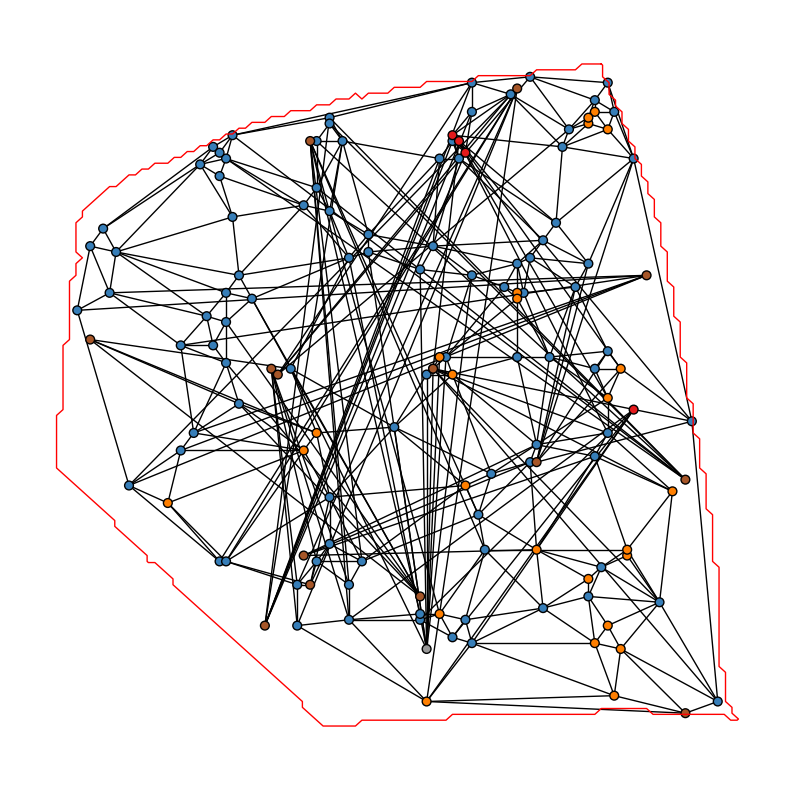

In [96]:
df_subset = cell_data.df.sample(10, random_state=0)

for i in range(len(df_subset)):
    # Info
    row = df_subset.iloc[i]
    key = '_'.join(row.iloc[:2])
    cell = row.iloc[2]
    
    # Get graph
    network = read_pkl(row.Path)
    network.remove_edges_from(list(nx.selfloop_edges(network)))
    
    labels = list(nx.get_node_attributes(network, 'labels').values())
    labels = np.argmax(labels, axis=1)
    node_colors = [colors_rgb_dict[PPIs_name[i]]/255 for i in labels]

    # Get contours
    contour_cell, contour_nuclei = get_contours(cell_data.contours, key, cell)
    
    # Plot
    f, ax = plt.subplots(figsize=(10,10))
    ax = plot_network(network,  node_colors , ax, node_size=40, edgecolors='k')
    plot_contour(contour_cell, None, ax, linewidth=1)
    axs[0].invert_yaxis()
    plt.show()
    break

In [93]:
from sklearn.preprocessing import OneHotEncoder
import networkx as nx
from sklearn import preprocessing
from libpysal import weights
from itertools import count
from libpysal.cg import voronoi_frames
import scipy 
from scipy.spatial import Delaunay
import itertools
import pickle

def create_network(x,y, t=50, scale=0.2):   

    # Get coordinates
    coordinates = np.vstack([x, y]).T
    points = coordinates - np.mean(coordinates, axis=0)
    
    # Delaunay
    tri = Delaunay(points)
    G = nx.Graph()
    for path in tri.simplices:
        G.add_nodes_from(path)
        edges = list(itertools.combinations(path, 2))
        G.add_edges_from(edges)
    
    # Euclidian distance
    distance = scipy.spatial.distance_matrix(points, points)
    l = t**2/np.log(t)
    distance_norm = np.exp(-distance**2/t)

    # distance_norm = np.where(distance>t, 0, np.exp(-distance*2/l))
    
    g_dist = nx.from_numpy_array(distance_norm)
    g = g_dist.edge_subgraph(G.edges()).copy() # Only keep delaunay edges
    return g

In [94]:
pos = nx.get_node_attributes(network, 'pos')
pos_a = np.array(list(pos.values()))
x = pos_a[:,1]
y = pos_a[:,0]

ValueError: 'c' argument has 139 elements, which is inconsistent with 'x' and 'y' with size 138.

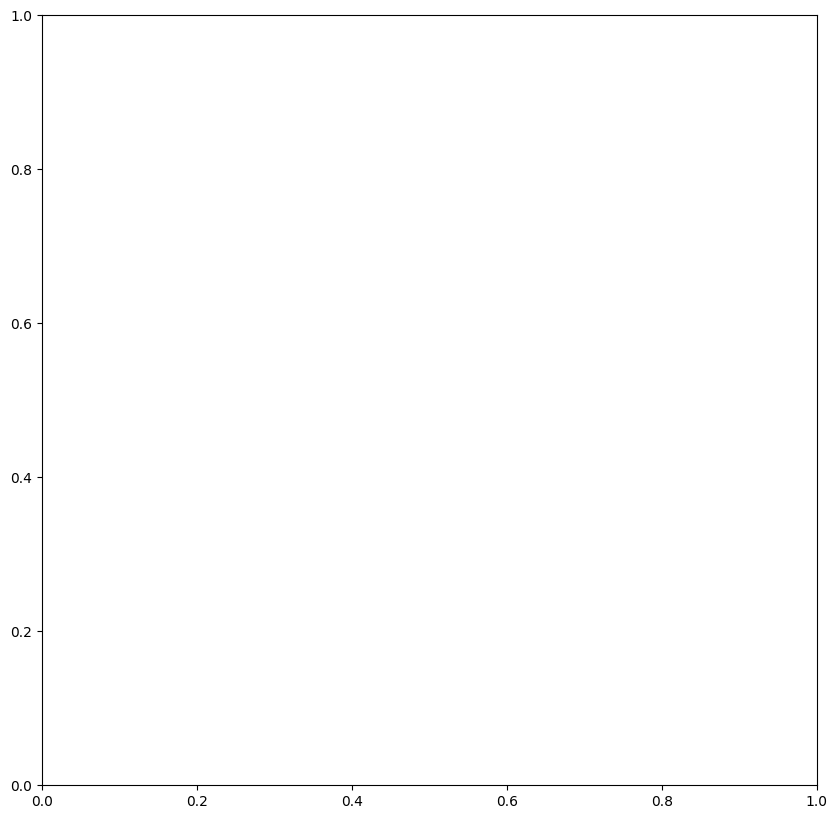

In [92]:
f, ax = plt.subplots(figsize=(10,10))
ax = nx.draw(g, pos_a, node_color=node_colors, with_labels=False, ax=ax)
plot_contour(contour_cell, None, ax, linewidth=1)
axs[0].invert_yaxis()
plt.show()

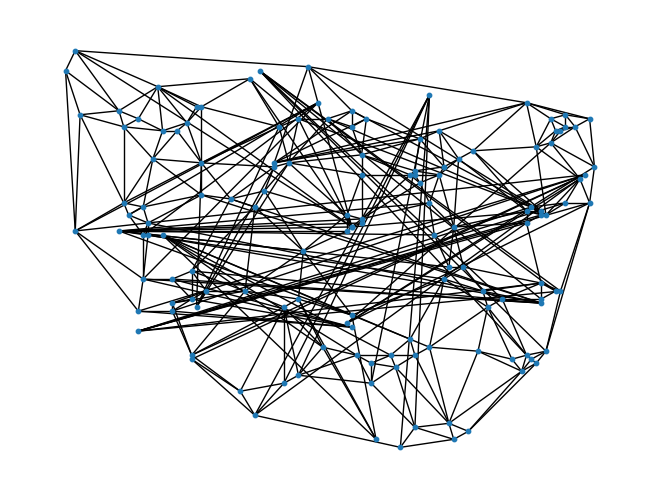

In [86]:
nx.draw(network, pos, with_labels=False, node_size=10)